## FMA CNN ##

Let's start by once again loading the data for the fma_small dataset. We'll join the genres on this dataframe, and then classify on the files that are only included in this dataset.

In [13]:
import pandas as pd
dataMatrix = pd.read_csv(r'D:\Analytics\extracted_audio_features_fma_small_dataset.csv', index_col=0)
genreMatrix = pd.read_csv(r'D:\Analytics\fma_clean_genres.csv', index_col=0)
ids = [int(s.split("\\")[-1][:-4]) for s in dataMatrix['names'].tolist()]
dataMatrix['ids'] = ids
merged = dataMatrix.join(genreMatrix.set_index('track id'), on='ids')
tracks_and_genres = pd.concat([merged['ids'], merged['genre']], axis=1)
tracks_and_genres.head()

,ids,genre
0,4849,International
0,2,Hip-Hop
0,43842,Folk
0,24745,International
0,31390,Folk


In [14]:
tracks_and_genres['genre'] = pd.Categorical(merged.genre)
merged.genre.value_counts()

Hip-Hop          1000
Pop              1000
Instrumental     1000
Experimental      999
Folk              999
International     999
Electronic        999
Rock              999
Name: genre, dtype: int64

In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
import tensorflow as tf

In [16]:
spectrogram_dir = r'D:/Analytics/spectrograms_fma_small/'
files = os.listdir(spectrogram_dir)

In [17]:
# need to remove images from files that are not otherwise in the dataset
print(files[0])

000002.png


In [18]:
images = [f for f in files if int(f[:-4]) in tracks_and_genres.ids.to_list()]

In [19]:
len(images)

7995

## Partitioning Data into Train and Test sets ##
We now have the class names for each image, and the list of images in our dataset. We'll do a 90-10 split between train and test. There will be some unequal weighting among the genres, but it should not be too great.

In [20]:
ordered_image_list = []
for i in tracks_and_genres.ids.to_list():
    for j in images:
        if int(j[:-4]) == i:
            ordered_image_list.append(j)

In [21]:
ordered_image_list[:10]

['004849.png',
 '000002.png',
 '043842.png',
 '024745.png',
 '031390.png',
 '011638.png',
 '038888.png',
 '015770.png',
 '005006.png',
 '000005.png']

In [22]:
s = pd.Series(ordered_image_list, name='images')
len(s)

7995

In [23]:
dataDict = {'ids': tracks_and_genres.ids, 'images': ordered_image_list, 'genre': tracks_and_genres.genre}

In [24]:
dataMatrix = pd.DataFrame(dataDict)
dataMatrix.head()

,ids,images,genre
0,4849,004849.png,International
0,2,000002.png,Hip-Hop
0,43842,043842.png,Folk
0,24745,024745.png,International
0,31390,031390.png,Folk


In [33]:
data_array = np.array([ordered_image_list, tracks_and_genres.genre.to_list()]).transpose()
print(np.shape(data_array))
np.random.shuffle(data_array)
print(data_array[0][0], data_array[0][1])

(7995, 2)
122166.png Experimental


In [34]:
train = data_array[:7195][:]
test = data_array[7195:][:]

## Loading Images and Pickling Data ##


122166.png


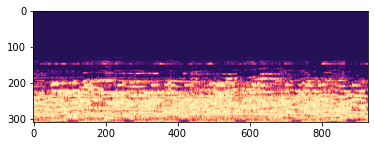

Experimental


In [35]:
# perform some EDA on the spectrogram image data
filename = train[0][0]
genre = train[0][1]
print(filename)
image_array = cv2.imread(os.path.join(spectrogram_dir,filename), cv2.IMREAD_GRAYSCALE)  # greyscale shouldn't matter versus heatmap
plt.imshow(image_array, cmap='magma')
plt.show()
print(genre)

In [36]:
print(image_array.shape)

(308, 930)


In [63]:
# check to see if all images are of the same size
shape = (308, 930)
for file in train[:][0]:
    image_array = cv2.imread(os.path.join(spectrogram_dir, filename), cv2.IMREAD_GRAYSCALE)
    if image_array.shape != shape:
        print('diff on: ', file)
        break

In [64]:
Xs = []
Ys = [] # classifier
for piece in train:
    image_array = cv2.imread(os.path.join(spectrogram_dir, piece[0]), cv2.IMREAD_GRAYSCALE)
    #image_array = cv2.resize(image_array, (250, 700))
    Xs.append(image_array)
    Ys.append(piece[1])

In [65]:
Xs = np.array(Xs)
Ys = np.array(Ys)

In [66]:
try:
    os.mkdir('FMA_SMALL_PICKLE')
except:
    print("Directory already exists.")
with open('FMA_SMALL_PICKLE\\X.pickle', 'wb') as pickle_out:
    pickle.dump(Xs, pickle_out)
with open('FMA_SMALL_PICKLE\\Y.pickle', 'wb') as pickle_out:
    pickle.dump(Ys, pickle_out)

Directory already exists.


In [4]:
## if picking up when left off, uncomment the following to load ##
"""
with open('FMA_SMALL_PICKLE\\X.pickle','rb') as pickle_in:
    Xs = pickle.load(pickle_in)
with open('FMA_SMALL_PICKLE\\Y.pickle','rb') as pickle_in:
    Ys = pickle.load(pickle_in)
"""

## Training the CNN ##
At this point we have everything we need to begin training the convolutional neural net. We'll be using Tensorflow for the remainder of the model building.

In [67]:
# tensorflow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras import regularizers

In [87]:
cnn_model = Sequential()
cnn_model.add(Conv2D(input_shape = (308, 930, 1), filters = 2, kernel_size=(5,5), padding='Same', kernel_regularizer=regularizers.l2(0.001),
                    activation='relu', strides=3))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(filters = 4, kernel_size=(5,5), padding='Same', activation='relu', strides=3))
cnn_model.add(MaxPool2D(pool_size=(2,2)))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(8, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
# Need to set Ys to categorical
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
encoder = preprocessing.LabelEncoder()
encoder.fit(Ys)
encoded_Y = encoder.transform(Ys)
Ys_onehot = to_categorical(encoded_Y)
Ys_onehot.shape

(7195, 8)

In [89]:
ES = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
MS = tf.keras.callbacks.ModelCheckpoint('fma.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

In [90]:
fit = cnn_model.fit(Xs.reshape(-1,308,930,1), Ys_onehot, validation_split=0.1, batch_size=10, epochs=30, verbose=1, callbacks=[MS])

Train on 6475 samples, validate on 720 samples
Epoch 1/30
6460/6475 [============================>.] - ETA: 0s - loss: 2.0451 - accuracy: 0.2034
Epoch 00001: val_loss improved from inf to 2.12922, saving model to fma.hdf5
6475/6475 [==============================] - 6s 869us/sample - loss: 2.0444 - accuracy: 0.2037 - val_loss: 2.1292 - val_accuracy: 0.1681
Epoch 2/30
6400/6475 [============================>.] - ETA: 0s - loss: 1.9183 - accuracy: 0.2658
Epoch 00002: val_loss improved from 2.12922 to 2.00363, saving model to fma.hdf5
6475/6475 [==============================] - 5s 717us/sample - loss: 1.9194 - accuracy: 0.2655 - val_loss: 2.0036 - val_accuracy: 0.2222
Epoch 3/30
6390/6475 [============================>.] - ETA: 0s - loss: 1.8075 - accuracy: 0.3199
Epoch 00003: val_loss improved from 2.00363 to 1.98852, saving model to fma.hdf5
6475/6475 [==============================] - 5s 717us/sample - loss: 1.8078 - accuracy: 0.3192 - val_loss: 1.9885 - val_accuracy: 0.2597
Epoch 4/3

In [11]:
def mkTrainingPlots(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper left')
    plt.show()

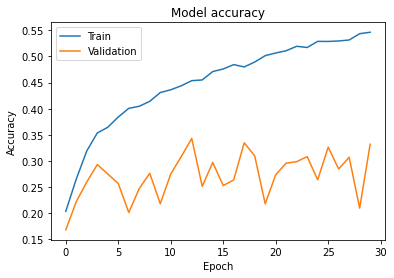

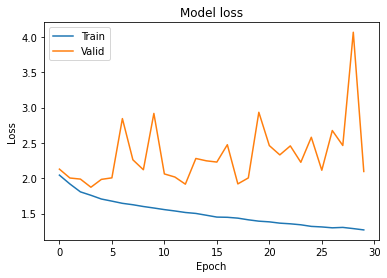

In [91]:
mkTrainingPlots(fit)

In [102]:
def test_predictions(test_array, model):
    Xs = []
    Y_actuals = []
    for piece in test_array:
        image_array = cv2.imread(os.path.join(spectrogram_dir, piece[0]), cv2.IMREAD_GRAYSCALE)
        #image_array = cv2.resize(image_array, (250, 700))
        Xs.append(image_array)
        Y_actuals.append(piece[1])
    Xs = np.array(Xs)
    Ys = np.array(Y_actuals)
    from sklearn import preprocessing
    from tensorflow.keras.utils import to_categorical
    encoder = preprocessing.LabelEncoder()
    encoder.fit(Ys)
    encoded_Y = encoder.transform(Y_actuals)
    Ys_onehot = to_categorical(encoded_Y)
    prediction = model.predict(Xs.reshape(-1, 308, 930, 1))
    return prediction

In [104]:
p = test_predictions(test, cnn_model)

In [106]:
p[0]

array([7.4976915e-01, 9.0957014e-03, 2.1857356e-04, 1.9426036e-01,
       5.4442585e-03, 2.0186279e-02, 8.3853761e-03, 1.2640271e-02],
      dtype=float32)